In [1]:
import pyspark
import pandas as pd

In [2]:
# Spark Session created
#from pyspark.sql import SparkSession
#spark = SparkSession.builder.getOrCreate()
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("timeseries") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()


In [3]:
#spark.stop()

In [4]:
df = pd.read_csv("tweets.csv")
df.tail(1)

,TweetID,UserID,Username,Timestamp,Text,State,County,City,Sentiment,COVID-related,AgeGroup,Age_Confidence,Gender,Gender_Confidence,Org_Confidence,Retweet
314533,1276666306507370496,24248058,YoshikoD,Fri Jun 26 23:59:01 +0000 2020,"""As the coronavirus surge across the South and...",Washington,Snohomish County,Snohomish,0.128,1,>=40,0.8488,female,0.9973,0.0006,1


In [5]:
# Convert Pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(df)

# Show the Spark DataFrame
spark_df.show(1)

+-------------------+------------------+---------+--------------------+--------------------+---------+------+----+---------+-------------+--------+--------------+------+-----------------+--------------+-------+
|            TweetID|            UserID| Username|           Timestamp|                Text|    State|County|City|Sentiment|COVID-related|AgeGroup|Age_Confidence|Gender|Gender_Confidence|Org_Confidence|Retweet|
+-------------------+------------------+---------+--------------------+--------------------+---------+------+----+---------+-------------+--------+--------------+------+-----------------+--------------+-------+
|1240790697504051203|724718492205875203|lionray98|Fri Mar 20 00:02:...|We learned today ...|Louisiana|   NaN| NaN|   0.7783|            1|   19-29|        0.9404|  male|           0.9999|           0.0|      1|
+-------------------+------------------+---------+--------------------+--------------------+---------+------+----+---------+-------------+--------+---------

In [6]:
print(spark_df.columns)

['TweetID', 'UserID', 'Username', 'Timestamp', 'Text', 'State', 'County', 'City', 'Sentiment', 'COVID-related', 'AgeGroup', 'Age_Confidence', 'Gender', 'Gender_Confidence', 'Org_Confidence', 'Retweet']


In [7]:
# Get the number of rows
num_rows = spark_df.count()
print(f"Number of rows: {num_rows}")
# Get the number of columns
num_columns = len(spark_df.columns)
print(f"Number of columns: {num_columns}")

Number of rows: 314534
Number of columns: 16


In [8]:
spark_df.select( 'Timestamp',  'Sentiment' ).show(5,truncate=False)

+------------------------------+---------+
|Timestamp                     |Sentiment|
+------------------------------+---------+
|Fri Mar 20 00:02:09 +0000 2020|0.7783   |
|Fri Mar 20 00:00:07 +0000 2020|-0.8202  |
|Fri Mar 20 00:00:10 +0000 2020|-0.4812  |
|Fri Mar 20 00:00:18 +0000 2020|0.836    |
|Fri Mar 20 00:02:54 +0000 2020|0.4588   |
+------------------------------+---------+
only showing top 5 rows



In [85]:

from pyspark.sql.functions import col, to_timestamp, from_utc_timestamp

# Set the legacy time parser policy
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Set the Spark time zone to UTC
spark.conf.set("spark.sql.session.timeZone", "UTC")

# Convert Timestamp to timestamp type
spark_df = spark_df.withColumn("Timestamp", to_timestamp(col("Timestamp"), "EEE MMM dd HH:mm:ss Z yyyy"))

# Select only the Timestamp column (showing as UTC)
timestamp_df = spark_df.select("Timestamp")

# Show the modified DataFrame with only the Timestamp column
spark_df.show(2, truncate=False)

# Check the current time zone of Spark session
print("Current Spark time zone:", spark.conf.get("spark.sql.session.timeZone"))

+-------------------+------------------+------------+-------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+------+----+---------+-------------+--------+--------------+------+-----------------+--------------+-------+----------+----+
|TweetID            |UserID            |Username    |Timestamp          |Text                                                                                                                                                                                                                                                                                 |State    |County|City|Sentiment|COVID-related|AgeGroup|Age_Confidence|Gender|Gender_Confidence|Org_Confidence|Retweet|Date      |Hour|
+-------------------+-------

In [23]:
# Filter for Louisiana and store in a variable
spark_df_la = spark_df.filter(col("State") == "Louisiana") \
    .select("State", "Timestamp", "Sentiment")

# Show 5 results for Louisiana
print("Results for Louisiana:")
spark_df_la.show(5, truncate=False)


Results for Louisiana:
+---------+-------------------+---------+
|State    |Timestamp          |Sentiment|
+---------+-------------------+---------+
|Louisiana|2020-03-20 00:02:09|0.7783   |
|Louisiana|2020-03-20 00:00:07|-0.8202  |
|Louisiana|2020-03-20 00:00:10|-0.4812  |
|Louisiana|2020-03-20 00:00:18|0.836    |
|Louisiana|2020-03-20 00:02:54|0.4588   |
+---------+-------------------+---------+
only showing top 5 rows



In [25]:
# Filter for Washington and store in a variable
spark_df_wa = spark_df.filter(col("State") == "Washington") \
    .select("State", "Timestamp", "Sentiment")

# Show 5 results for Washington
print("Results for Washington:")
spark_df_wa.show(5, truncate=False)


Results for Washington:
+----------+-------------------+---------+
|State     |Timestamp          |Sentiment|
+----------+-------------------+---------+
|Washington|2020-03-21 00:00:21|-0.7269  |
|Washington|2020-03-21 00:01:16|-0.3883  |
|Washington|2020-03-21 00:01:17|-0.4318  |
|Washington|2020-03-21 00:00:41|-0.8633  |
|Washington|2020-03-21 00:01:31|-0.5574  |
+----------+-------------------+---------+
only showing top 5 rows



## Sentiment Analysis during Stay at Home in LA 

In [37]:
from pyspark.sql import functions as F

la_period_1 = spark_df_la.filter(
    (F.month(F.col("Timestamp")) == 3) & 
    (F.year(F.col("Timestamp")) == 2020)
)
# Optionally, show the filtered DataFrame
la_period_1.orderBy(F.desc("Timestamp")).show(5, truncate=False)


+---------+-------------------+---------+
|State    |Timestamp          |Sentiment|
+---------+-------------------+---------+
|Louisiana|2020-03-24 23:59:59|0.6705   |
|Louisiana|2020-03-24 23:59:55|0.0      |
|Louisiana|2020-03-24 23:59:54|-0.5423  |
|Louisiana|2020-03-24 23:59:44|0.3903   |
|Louisiana|2020-03-24 23:59:43|-0.8831  |
+---------+-------------------+---------+
only showing top 5 rows



In [28]:
la_stay_home_date_range = la_period_1.select(
    F.min(F.to_date("Timestamp")).alias("min_date"),
    F.max(F.to_date("Timestamp")).alias("max_date")
)

# Show the DataFrame
la_stay_home_date_range.show()

+----------+----------+
|  min_date|  max_date|
+----------+----------+
|2020-03-20|2020-03-24|
+----------+----------+



In [30]:
from pyspark.sql import functions as F

# Define the stay-at-home order timestamp
stay_at_home_order = "2020-03-22 14:00:00"
stay_at_home_order_ts = F.to_timestamp(F.lit(stay_at_home_order))

# Sort the DataFrame based on Timestamp
la_period_1_sorted = la_period_1.sort(F.col("Timestamp").asc())

# Filter the DataFrame based on the date range
la_stay_home_date_range_df = la_period_1_sorted.filter(
    (F.col("Timestamp") >= la_stay_home_date_range.first()["min_date"]) &
    (F.col("Timestamp") <= la_stay_home_date_range.first()["max_date"])
)


In [31]:
# Calculate average sentiment before and after the order
avg_sentiment_before = la_stay_home_date_range_df.filter(F.col("Timestamp") < stay_at_home_order_ts) \
    .agg(F.avg("Sentiment").alias("avg_sentiment")).collect()[0]["avg_sentiment"]

avg_sentiment_after = la_stay_home_date_range_df.filter(F.col("Timestamp") >= stay_at_home_order_ts) \
    .agg(F.avg("Sentiment").alias("avg_sentiment")).collect()[0]["avg_sentiment"]

# Print the results
print(f"Average Sentiment Before Stay-at-Home Order: {avg_sentiment_before}")
print(f"Average Sentiment After Stay-at-Home Order: {avg_sentiment_after}")


Average Sentiment Before Stay-at-Home Order: 0.020739948106626282
Average Sentiment After Stay-at-Home Order: 0.02051747001669986


In [40]:
la_period_1_sorted.filter(F.to_date(F.col("Timestamp")) == "2020-03-24").show()


+---------+-------------------+---------+
|    State|          Timestamp|Sentiment|
+---------+-------------------+---------+
|Louisiana|2020-03-24 00:00:03|  -0.4588|
|Louisiana|2020-03-24 00:00:11|   0.2732|
|Louisiana|2020-03-24 00:00:13|      0.0|
|Louisiana|2020-03-24 00:00:17|  -0.4215|
|Louisiana|2020-03-24 00:00:18|      0.0|
|Louisiana|2020-03-24 00:00:23|   0.9412|
|Louisiana|2020-03-24 00:00:25|      0.0|
|Louisiana|2020-03-24 00:00:27|    0.296|
|Louisiana|2020-03-24 00:00:28|   -0.296|
|Louisiana|2020-03-24 00:00:40|   0.2732|
|Louisiana|2020-03-24 00:00:43|  -0.3612|
|Louisiana|2020-03-24 00:00:43|      0.0|
|Louisiana|2020-03-24 00:00:44|      0.0|
|Louisiana|2020-03-24 00:00:46|      0.0|
|Louisiana|2020-03-24 00:00:51|      0.0|
|Louisiana|2020-03-24 00:00:52|   0.8225|
|Louisiana|2020-03-24 00:00:54|  -0.5719|
|Louisiana|2020-03-24 00:00:58|  -0.4939|
|Louisiana|2020-03-24 00:01:00|    0.802|
|Louisiana|2020-03-24 00:01:02|      0.0|
+---------+-------------------+---

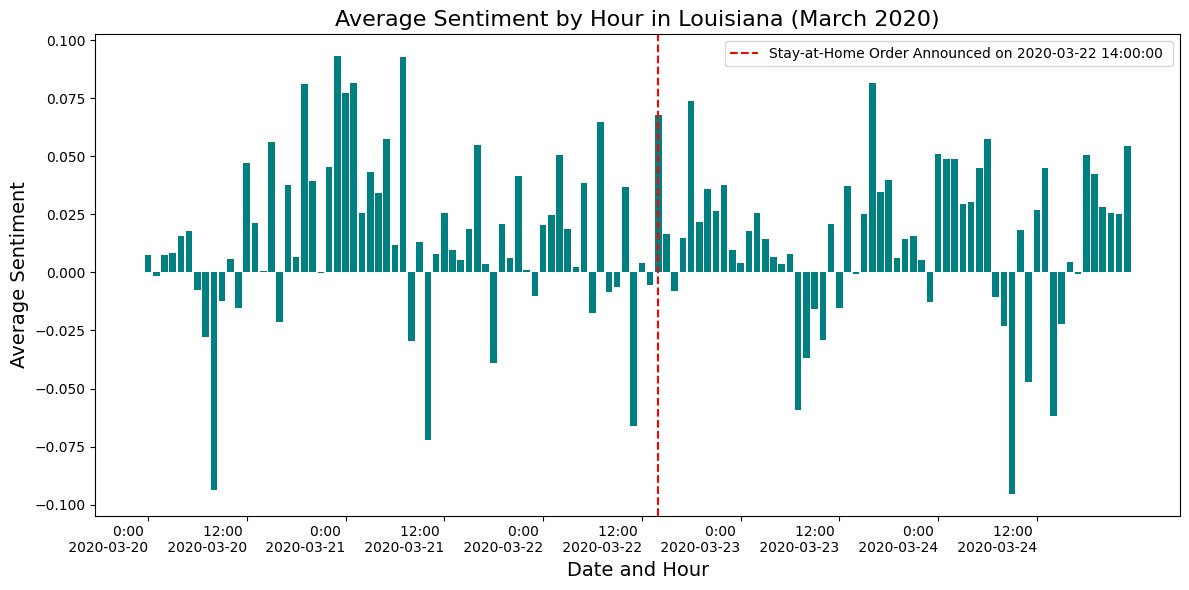

In [46]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Define the stay-at-home order timestamp
stay_at_home_order = "2020-03-22 14:00:00"
stay_at_home_order_ts = F.to_timestamp(F.lit(stay_at_home_order))

# Step 2: Extract Hour and Date from Timestamp
la_stay_home_date_range_df = la_period_1_sorted.withColumn("Hour", F.hour(F.col("Timestamp"))) \
    .withColumn("Date", F.to_date(F.col("Timestamp")))

# Step 3: Calculate average sentiment per hour using the new DataFrame
avg_sentiment_hourly = la_stay_home_date_range_df.groupBy("Date", "Hour") \
    .agg(F.avg("Sentiment").alias("avg_sentiment"))

# Step 4: Collect the data for plotting and sort it by date and hour
hourly_data = avg_sentiment_hourly.orderBy("Date", "Hour").collect()

# Prepare data for plotting
dates = [row['Date'] for row in hourly_data]
hours = [row['Hour'] for row in hourly_data]
avg_sentiments = [row['avg_sentiment'] for row in hourly_data]

# Combine date and hour for x-axis labels
date_hour_labels = [f"{date} {hour}:00" for date, hour in zip(dates, hours)]

# Step 5: Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(date_hour_labels, avg_sentiments, color='teal')

# Mark the stay-at-home order announcement time
plt.axvline(x="2020-03-22 14:00", color='red', linestyle='--', label='Stay-at-Home Order Announced on 2020-03-22 14:00:00 ')

# Adding titles and labels
plt.title('Average Sentiment by Hour in Louisiana (March 2020)', fontsize=16)
plt.xlabel('Date and Hour', fontsize=14)
plt.ylabel('Average Sentiment', fontsize=14)

# Customize x-ticks to avoid clutter
plt.xticks(ticks=range(0, len(date_hour_labels), max(1, len(date_hour_labels)//10)),
           labels=[f"{hours[i]}:00 \n {dates[i]}" for i in range(0, len(date_hour_labels), max(1, len(date_hour_labels)//10))],
           ha='right', fontsize=10)

# Display the legend
plt.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Sentiment Analysis during Mask Mandate Order in LA 

In [47]:
la_period_2 = spark_df_la.filter(
    (F.month(F.col("Timestamp")) == 7) & 
    (F.year(F.col("Timestamp")) == 2020)
)
# Optionally, show the filtered DataFrame
la_period_2.orderBy(F.desc("Timestamp")).show(5, truncate=False)

+---------+-------------------+---------+
|State    |Timestamp          |Sentiment|
+---------+-------------------+---------+
|Louisiana|2020-07-13 23:59:54|-0.9595  |
|Louisiana|2020-07-13 23:59:53|-0.2247  |
|Louisiana|2020-07-13 23:59:33|-0.938   |
|Louisiana|2020-07-13 23:59:19|0.0      |
|Louisiana|2020-07-13 23:59:13|0.0      |
+---------+-------------------+---------+
only showing top 5 rows



In [48]:
la_mask_mandate_date_range = la_period_2.select(
    F.min(F.to_date("Timestamp")).alias("min_date"),
    F.max(F.to_date("Timestamp")).alias("max_date")
)

# Show the DataFrame
la_mask_mandate_date_range.show()

+----------+----------+
|  min_date|  max_date|
+----------+----------+
|2020-07-09|2020-07-13|
+----------+----------+



In [52]:
from pyspark.sql import functions as F

# Define the stay-at-home order timestamp
mask_mandate_order = "2020-07-11 14:30:00"
mask_mandate_order_ts = F.to_timestamp(F.lit(mask_mandate_order))

# Sort the DataFrame based on Localized_Timestamp
la_period_2_sorted = la_period_2.sort(F.col("Timestamp").asc())

# Filter the DataFrame based on the date range
la_mask_mandate_date_range_df = la_period_2_sorted.filter(
    (F.col("Timestamp") >= la_mask_mandate_date_range.first()["min_date"]) &
    (F.col("Timestamp") <= la_mask_mandate_date_range.first()["max_date"])
)
la_mask_mandate_date_range_df.show(5)

+---------+-------------------+---------+
|    State|          Timestamp|Sentiment|
+---------+-------------------+---------+
|Louisiana|2020-07-09 00:00:01|   0.7506|
|Louisiana|2020-07-09 00:00:25|  -0.8377|
|Louisiana|2020-07-09 00:00:54|  -0.6249|
|Louisiana|2020-07-09 00:01:08|      0.0|
|Louisiana|2020-07-09 00:01:40|   0.6705|
+---------+-------------------+---------+
only showing top 5 rows



In [53]:
# Calculate average sentiment before and after the order
avg_sentiment_before = la_mask_mandate_date_range_df.filter(F.col("Timestamp") < mask_mandate_order_ts) \
    .agg(F.avg("Sentiment").alias("avg_sentiment")).collect()[0]["avg_sentiment"]

avg_sentiment_after = la_mask_mandate_date_range_df.filter(F.col("Timestamp") >= mask_mandate_order_ts) \
    .agg(F.avg("Sentiment").alias("avg_sentiment")).collect()[0]["avg_sentiment"]

# Print the results
print(f"Average Sentiment Before Stay-at-Home Order: {avg_sentiment_before}")
print(f"Average Sentiment After Stay-at-Home Order: {avg_sentiment_after}")


Average Sentiment Before Stay-at-Home Order: -0.014947287014061133
Average Sentiment After Stay-at-Home Order: -0.016213403658182288


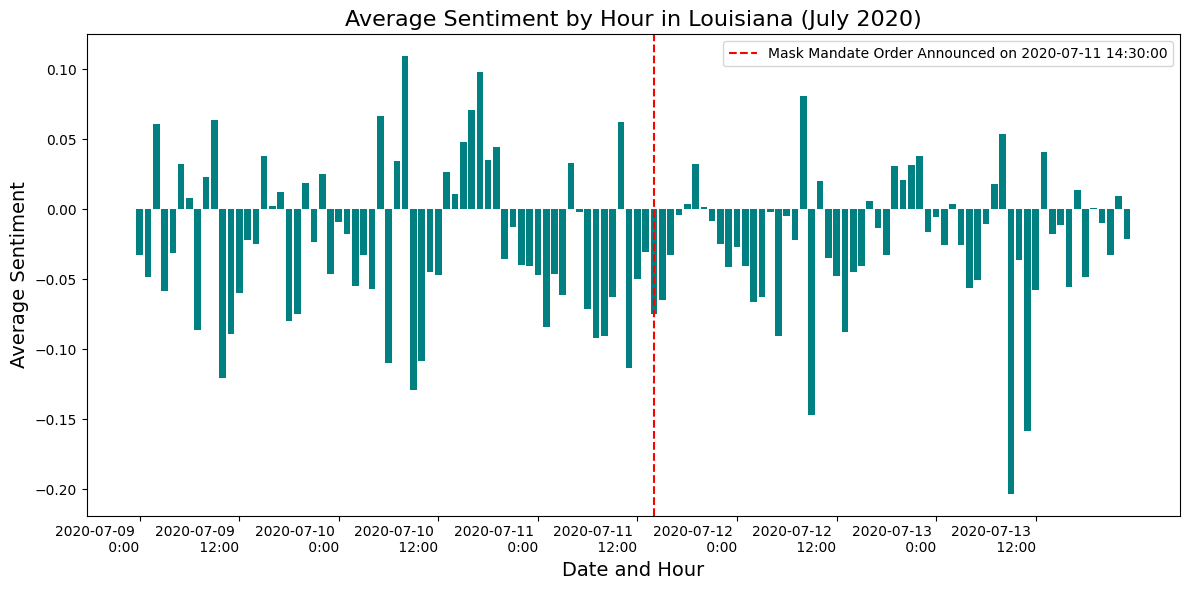

In [61]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Define the mask mandate order timestamp
mask_mandate_order = "2020-07-11 14:30:00"

# Step 2: Extract Hour and Date from Timestamp
la_mask_mandate_date_range_df = la_period_2_sorted.withColumn("Hour", F.hour(F.col("Timestamp"))) \
    .withColumn("Date", F.to_date(F.col("Timestamp")))

# Step 3: Calculate average sentiment per hour using the new DataFrame
avg_sentiment_hourly = la_mask_mandate_date_range_df.groupBy("Date", "Hour") \
    .agg(F.avg("Sentiment").alias("avg_sentiment"))

# Step 4: Collect the data for plotting and sort it by date and hour
hourly_data = avg_sentiment_hourly.orderBy("Date", "Hour").collect()

# Prepare data for plotting
dates = [row['Date'] for row in hourly_data]
hours = [row['Hour'] for row in hourly_data]
avg_sentiments = [row['avg_sentiment'] for row in hourly_data]

# Combine date and hour for x-axis labels
date_hour_labels = [f"{date} {hour}:00" for date, hour in zip(dates, hours)]

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(date_hour_labels, avg_sentiments, color='teal')

# Convert the mask mandate order to a datetime object
mask_mandate_datetime = datetime.strptime(mask_mandate_order, '%Y-%m-%d %H:%M:%S')

# Mark the mask mandate announcement time
# We need to convert the datetime to a format that matplotlib understands
plt.axvline(x=date_hour_labels.index(f"{mask_mandate_datetime.strftime('%Y-%m-%d')} 14:00"), 
            color='red', linestyle='--', 
            label='Mask Mandate Order Announced on 2020-07-11 14:30:00')

# Adding titles and labels
plt.title('Average Sentiment by Hour in Louisiana (July 2020)', fontsize=16)
plt.xlabel('Date and Hour', fontsize=14)
plt.ylabel('Average Sentiment', fontsize=14)

# Customize x-ticks to avoid clutter
plt.xticks(ticks=range(0, len(date_hour_labels), max(1, len(date_hour_labels)//10)),
           labels=[f"{dates[i]} \n {hours[i]}:00" for i in range(0, len(date_hour_labels), max(1, len(date_hour_labels)//10))],
           ha='right', fontsize=10)

# Display the legend
plt.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Sentiment Analysis during Stay at Home in WA

In [62]:
from pyspark.sql import functions as F

wa_period_1 = spark_df_wa.filter(
    (F.month(F.col("Timestamp")) == 3) & 
    (F.year(F.col("Timestamp")) == 2020)
)
# Optionally, show the filtered DataFrame
wa_period_1.orderBy(F.desc("Timestamp")).show(5, truncate=False)


+----------+-------------------+---------+
|State     |Timestamp          |Sentiment|
+----------+-------------------+---------+
|Washington|2020-03-25 23:59:41|0.3843   |
|Washington|2020-03-25 23:59:40|0.0      |
|Washington|2020-03-25 23:59:37|0.7003   |
|Washington|2020-03-25 23:59:36|-0.8472  |
|Washington|2020-03-25 23:59:35|0.5106   |
+----------+-------------------+---------+
only showing top 5 rows



In [64]:
wa_stay_home_date_range = wa_period_1.select(
    F.min(F.to_date("Timestamp")).alias("min_date"),
    F.max(F.to_date("Timestamp")).alias("max_date")
)

# Show the DataFrame
wa_stay_home_date_range.show()

+----------+----------+
|  min_date|  max_date|
+----------+----------+
|2020-03-21|2020-03-25|
+----------+----------+



In [65]:
from pyspark.sql import functions as F

# Define the stay-at-home order timestamp
wa_stay_at_home_order = "2020-03-23 17:30:00"
wa_stay_at_home_order_ts = F.to_timestamp(F.lit(stay_at_home_order))

# Sort the DataFrame based on Timestamp
wa_period_1_sorted = wa_period_1.sort(F.col("Timestamp").asc())

# Filter the DataFrame based on the date range
wa_stay_home_date_range_df = wa_period_1_sorted.filter(
    (F.col("Timestamp") >= wa_stay_home_date_range.first()["min_date"]) &
    (F.col("Timestamp") <= wa_stay_home_date_range.first()["max_date"])
)


In [69]:
# Calculate average sentiment before and after the order
avg_sentiment_before = wa_stay_home_date_range_df.filter(F.col("Timestamp") < wa_stay_at_home_order_ts) \
    .agg(F.avg("Sentiment").alias("avg_sentiment")).collect()[0]["avg_sentiment"]

avg_sentiment_after = wa_stay_home_date_range_df.filter(F.col("Timestamp") >= wa_stay_at_home_order_ts) \
    .agg(F.avg("Sentiment").alias("avg_sentiment")).collect()[0]["avg_sentiment"]

# Print the results
print(f"Average Sentiment Before Stay-at-Home Order in WA: {avg_sentiment_before}")
print(f"Average Sentiment After Stay-at-Home Order in WA: {avg_sentiment_after}")


Average Sentiment Before Stay-at-Home Order in WA: 0.0018278845666176561
Average Sentiment After Stay-at-Home Order in WA: 0.0071006851164698605


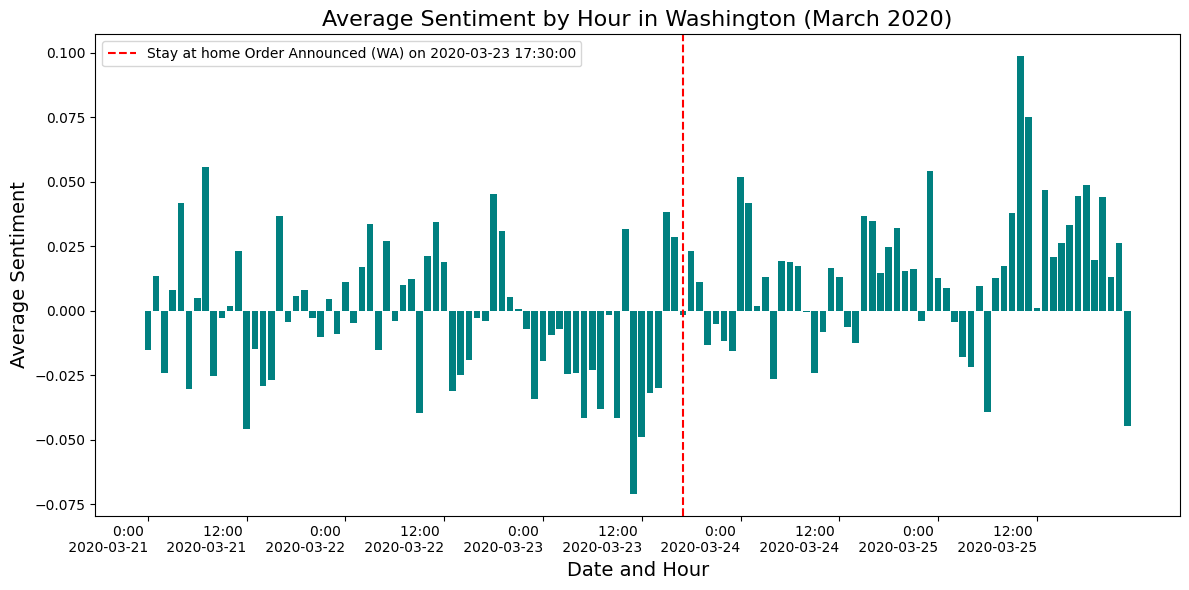

In [72]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

wa_stay_at_home_order = "2020-03-23 17:30:00"
# Step 2: Extract Hour and Date from Timestamp
wa_stay_home_date_range_df = wa_period_1_sorted.withColumn("Hour", F.hour(F.col("Timestamp"))) \
    .withColumn("Date", F.to_date(F.col("Timestamp")))

# Step 3: Calculate average sentiment per hour using the new DataFrame
avg_sentiment_hourly = wa_stay_home_date_range_df.groupBy("Date", "Hour") \
    .agg(F.avg("Sentiment").alias("avg_sentiment"))

# Step 4: Collect the data for plotting and sort it by date and hour
hourly_data = avg_sentiment_hourly.orderBy("Date", "Hour").collect()

# Prepare data for plotting
dates = [row['Date'] for row in hourly_data]
hours = [row['Hour'] for row in hourly_data]
avg_sentiments = [row['avg_sentiment'] for row in hourly_data]

# Combine date and hour for x-axis labels
date_hour_labels = [f"{date} {hour}:00" for date, hour in zip(dates, hours)]

# Step 5: Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(date_hour_labels, avg_sentiments, color='teal')

# Convert the mask mandate order to a datetime object
wa_stay_home_datetime = datetime.strptime(wa_stay_at_home_order, '%Y-%m-%d %H:%M:%S')

# Mark the mask mandate announcement time
# We need to convert the datetime to a format that matplotlib understands
plt.axvline(x=date_hour_labels.index(f"{wa_stay_home_datetime.strftime('%Y-%m-%d')} 17:00"), 
            color='red', linestyle='--', 
            label='Stay at home Order Announced (WA) on 2020-03-23 17:30:00')



# Mark the stay-at-home order announcement time
#plt.axvline(x="2020-03-23 17:30:00", color='red', linestyle='--', label='Stay-at-Home Order Announced on 2020-03-23 17:30:00 ')

# Adding titles and labels
plt.title('Average Sentiment by Hour in Washington (March 2020)', fontsize=16)
plt.xlabel('Date and Hour', fontsize=14)
plt.ylabel('Average Sentiment', fontsize=14)

# Customize x-ticks to avoid clutter
plt.xticks(ticks=range(0, len(date_hour_labels), max(1, len(date_hour_labels)//10)),
           labels=[f"{hours[i]}:00 \n {dates[i]}" for i in range(0, len(date_hour_labels), max(1, len(date_hour_labels)//10))],
           ha='right', fontsize=10)

# Display the legend
plt.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Sentiment Analysis during Mask Mandate in WA

In [73]:
from pyspark.sql import functions as F

wa_period_2 = spark_df_wa.filter(
    (F.month(F.col("Timestamp")) == 6) & 
    (F.year(F.col("Timestamp")) == 2020)
)
# Optionally, show the filtered DataFrame
wa_period_2.orderBy(F.desc("Timestamp")).show(5, truncate=False)


+----------+-------------------+---------+
|State     |Timestamp          |Sentiment|
+----------+-------------------+---------+
|Washington|2020-06-26 23:59:58|-0.2023  |
|Washington|2020-06-26 23:59:53|0.0      |
|Washington|2020-06-26 23:59:51|-0.6705  |
|Washington|2020-06-26 23:59:43|0.5927   |
|Washington|2020-06-26 23:59:37|-0.4767  |
+----------+-------------------+---------+
only showing top 5 rows



In [74]:
wa_mask_mandate_date_range = wa_period_2.select(
    F.min(F.to_date("Timestamp")).alias("min_date"),
    F.max(F.to_date("Timestamp")).alias("max_date")
)

# Show the DataFrame
wa_mask_mandate_date_range.show()

+----------+----------+
|  min_date|  max_date|
+----------+----------+
|2020-06-22|2020-06-26|
+----------+----------+



In [75]:
from pyspark.sql import functions as F

# Define the mask_mandate order timestamp
wa_mask_mandate_order = "2020-06-23 15:00:00"
wa_mask_mandate_order_ts = F.to_timestamp(F.lit(wa_mask_mandate_order))

# Sort the DataFrame based on Localized_Timestamp
wa_period_2_sorted = wa_period_2.sort(F.col("Timestamp").asc())

# Filter the DataFrame based on the date range
wa_mask_mandate_date_range_df = wa_period_2_sorted.filter(
    (F.col("Timestamp") >= wa_mask_mandate_date_range.first()["min_date"]) &
    (F.col("Timestamp") <= wa_mask_mandate_date_range.first()["max_date"])
)
wa_mask_mandate_date_range_df.show(5)

+----------+-------------------+---------+
|     State|          Timestamp|Sentiment|
+----------+-------------------+---------+
|Washington|2020-06-22 00:00:01|   0.5967|
|Washington|2020-06-22 00:00:10|  -0.1027|
|Washington|2020-06-22 00:00:22|  -0.7351|
|Washington|2020-06-22 00:00:30|  -0.8225|
|Washington|2020-06-22 00:00:53|  -0.9361|
+----------+-------------------+---------+
only showing top 5 rows



In [78]:
# Calculate average sentiment before and after the order
avg_sentiment_before = wa_mask_mandate_date_range_df.filter(F.col("Timestamp") < wa_mask_mandate_order_ts) \
    .agg(F.avg("Sentiment").alias("avg_sentiment")).collect()[0]["avg_sentiment"]

avg_sentiment_after = wa_mask_mandate_date_range_df.filter(F.col("Timestamp") >= wa_mask_mandate_order_ts) \
    .agg(F.avg("Sentiment").alias("avg_sentiment")).collect()[0]["avg_sentiment"]

# Print the results
print(f"Average Sentiment Before mask_mandate Order in WA: {avg_sentiment_before}")
print(f"Average Sentiment After mask_mandate Order in WA: {avg_sentiment_after}")


Average Sentiment Before mask_mandate Order in WA: -0.02836936226167027
Average Sentiment After mask_mandate Order in WA: -0.04143829404772223


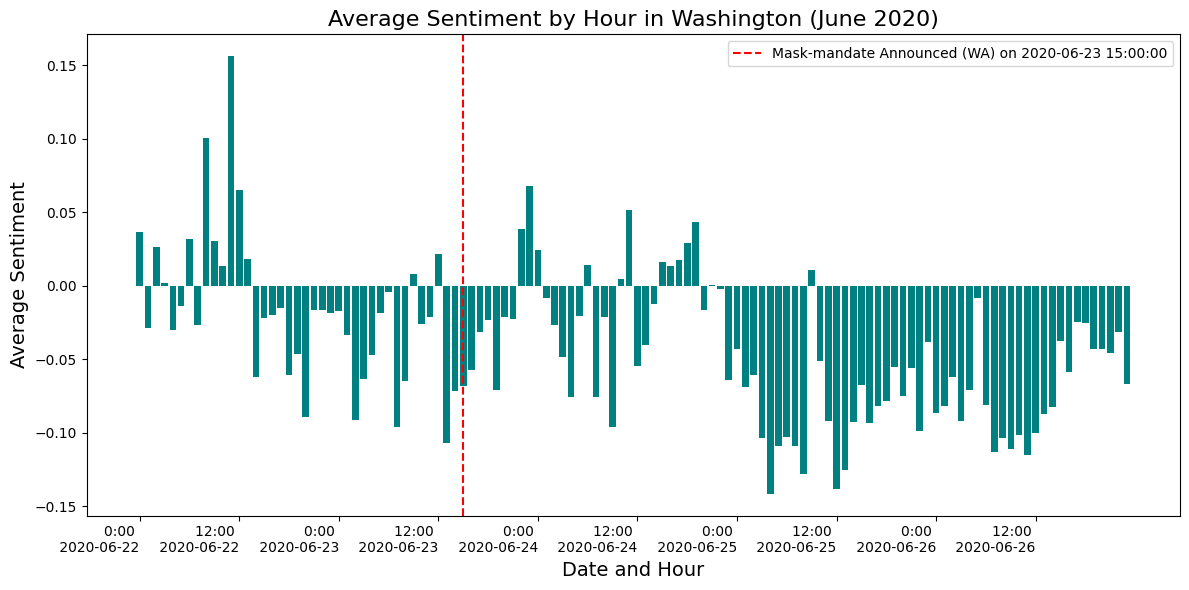

In [81]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Define the stay-at-home order timestamp
wa_mask_mandate_order = "2020-06-23 15:00:00"
wa_mask_mandate_order_ts = F.to_timestamp(F.lit(wa_mask_mandate_order))

# Step 2: Extract Hour and Date from Timestamp
wa_mask_mandate_date_range_df = wa_period_2_sorted.withColumn("Hour", F.hour(F.col("Timestamp"))) \
    .withColumn("Date", F.to_date(F.col("Timestamp")))

# Step 3: Calculate average sentiment per hour using the new DataFrame
avg_sentiment_hourly = wa_mask_mandate_date_range_df.groupBy("Date", "Hour") \
    .agg(F.avg("Sentiment").alias("avg_sentiment"))

# Step 4: Collect the data for plotting and sort it by date and hour
hourly_data = avg_sentiment_hourly.orderBy("Date", "Hour").collect()

# Prepare data for plotting
dates = [row['Date'] for row in hourly_data]
hours = [row['Hour'] for row in hourly_data]
avg_sentiments = [row['avg_sentiment'] for row in hourly_data]

# Combine date and hour for x-axis labels
date_hour_labels = [f"{date} {hour}:00" for date, hour in zip(dates, hours)]

# Step 5: Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(date_hour_labels, avg_sentiments, color='teal')

# Mark the mask-mandate order announcement time
#plt.axvline(x="2020-06-23 15:00:00", color='red', linestyle='--', label='Mask Mandate Order Announced on 2020-06-23 15:00:00 ')

# Convert the mask mandate order to a datetime object
wa_mask_mandate_datetime = datetime.strptime(wa_mask_mandate_order, '%Y-%m-%d %H:%M:%S')

# Mark the mask mandate announcement time
# We need to convert the datetime to a format that matplotlib understands
plt.axvline(x=date_hour_labels.index(f"{wa_mask_mandate_datetime.strftime('%Y-%m-%d')} 15:00"), 
            color='red', linestyle='--', 
            label='Mask-mandate Announced (WA) on 2020-06-23 15:00:00')



# Adding titles and labels
plt.title('Average Sentiment by Hour in Washington (June 2020)', fontsize=16)
plt.xlabel('Date and Hour', fontsize=14)
plt.ylabel('Average Sentiment', fontsize=14)

# Customize x-ticks to avoid clutter
plt.xticks(ticks=range(0, len(date_hour_labels), max(1, len(date_hour_labels)//10)),
           labels=[f"{hours[i]}:00 \n {dates[i]}" for i in range(0, len(date_hour_labels), max(1, len(date_hour_labels)//10))],
           ha='right', fontsize=10)

# Display the legend
plt.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [84]:
import nbformat

# Load the notebook file
with open('time_series.ipynb', 'r', encoding='utf-8') as f:
    notebook = nbformat.read(f, as_version=4)

# Count the lines of code in all code cells
code_lines = 0
for cell in notebook['cells']:
    if cell['cell_type'] == 'code':
        code_lines += len(cell['source'].splitlines())

print(f"Total lines of code: {code_lines}")


Total lines of code: 461


In [1]:
import json

def count_spark_operations(notebook_path):
    # Open the notebook file with utf-8 encoding
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook = json.load(f)

    spark_operation_count = 0
    for cell in notebook['cells']:
        if cell['cell_type'] == 'code':
            code = cell['source']
            # Check for common Spark operation keywords
            for line in code:
                if any(op in line for op in ['filter', 'select', 'groupBy', 'join', 'map', 'reduce', 'show', 'collect']):
                    spark_operation_count += 1

    return spark_operation_count

# Example usage
notebook_path = 'time_series.ipynb'  # Update this with your notebook path
operation_count = count_spark_operations(notebook_path)
print(f"Number of Spark Operations Found: {operation_count}")


Number of Spark Operations Found: 66
